In [ ]:
# Install TIMM and relevant libraries
!pip install timm datasets
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
# Import Libraries
import timm
import torch
import torch.nn as nn
from google.colab import drive
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, datasets, models
import wandb

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/NairaNotes"))
print(os.listdir("/content/drive/MyDrive/NairaNotes/Train"))

['Test', 'Train', 'val']
['500', '50', '5', '200', '20', '10', '100', '1000']


In [ ]:
# Define the base path to NairaNotes
base_path = '/content/drive/MyDrive/NairaNotes'

# Load datasets without any transforms
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'Train'))
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'val'))
test_dataset = datasets.ImageFolder(os.path.join(base_path, 'Test'))

# Verify the dataset
print("Classes:", train_dataset.classes)
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['10', '100', '1000', '20', '200', '5', '50', '500']
Train samples: 1736
Validation samples: 216
Test samples: 90


In [ ]:
# Training Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Test/Val transformations
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply the transform to datasets
train_dataset.transform = train_transform
val_dataset.transform =  test_val_transform
test_dataset.transform = test_val_transform

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
image, label = train_dataset[1700]
image.shape, label

(torch.Size([3, 224, 224]), 7)

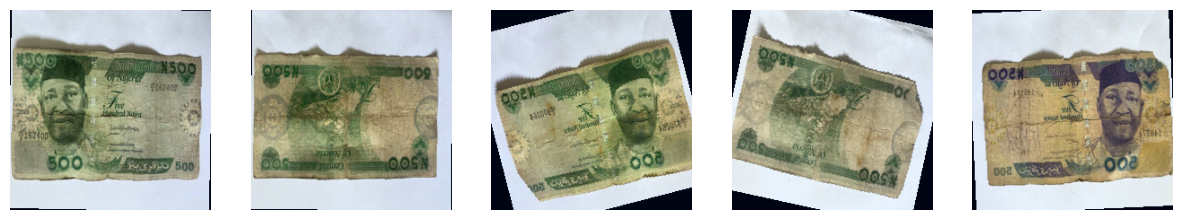

In [ ]:
# Visualize some images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Get the total number of samples
n = len(train_dataset)


for i, idx in enumerate(range(n - 5, n)):
    image, _ = train_dataset[idx]  # Ignore label
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    axes[i].imshow(image_np)
    axes[i].axis('off')

plt.show()

In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Setup the ResNet50 model
model_resnet50 = models.resnet50(pretrained=True).to(device)

num_classes = len(train_dataset)

#Loss and Optimizer
loss_fn = CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=0.003)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.2MB/s]


In [ ]:
from sklearn.metrics import classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)
    return {
        "accuracy": (predictions == labels).mean(),
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"]
    }

In [ ]:
wandb.init(
    project="naira-classification",
    name="resnet50_run",
    config={
        "model": "ResNet50",
        "learning_rate": 0.003,
        "batch_size": 32,
        "epochs": 5,
        "dataset": "Naira",
        "num_classes": num_classes
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abdulrahmanabdullahigarba (abdulrahmanabdullahigarba-federal-university-birnin-kebbi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Training model
def train_model(model, train_loader, val_loader, criterion, device, metrics, optimizer, epochs):
    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        train_loss = train_loss / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss = val_loss / val_total

        # Step learning rate scheduler
        #scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": 0.003
        })


        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [ ]:
train_model(
    model=model_resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    #scheduler=scheduler,
    metrics=compute_metrics,
    device=device,
    epochs=5,
)



Epoch 1/5
------------------------------


100%|██████████| 55/55 [30:35<00:00, 33.38s/it]


Train Loss: 0.0531 | Train Acc: 0.4672
Val Loss: 0.0463 | Val Acc: 0.4907

Epoch 2/5
------------------------------


100%|██████████| 55/55 [21:14<00:00, 23.17s/it]


Train Loss: 0.0259 | Train Acc: 0.7333
Val Loss: 0.0901 | Val Acc: 0.5509

Epoch 3/5
------------------------------


100%|██████████| 55/55 [21:15<00:00, 23.18s/it]


Train Loss: 0.0203 | Train Acc: 0.7794
Val Loss: 0.0202 | Val Acc: 0.7870

Epoch 4/5
------------------------------


100%|██████████| 55/55 [20:49<00:00, 22.72s/it]


Train Loss: 0.0149 | Train Acc: 0.8508
Val Loss: 0.0517 | Val Acc: 0.5694

Epoch 5/5
------------------------------


100%|██████████| 55/55 [20:44<00:00, 22.63s/it]


Train Loss: 0.0096 | Train Acc: 0.8940
Val Loss: 0.0120 | Val Acc: 0.8333


train loss 89.4%
val acc 83.3%

In [ ]:
import random
def show_random_predictions(model, train_loader, class_names, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(train_dataset)), num_samples)
    samples = [train_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

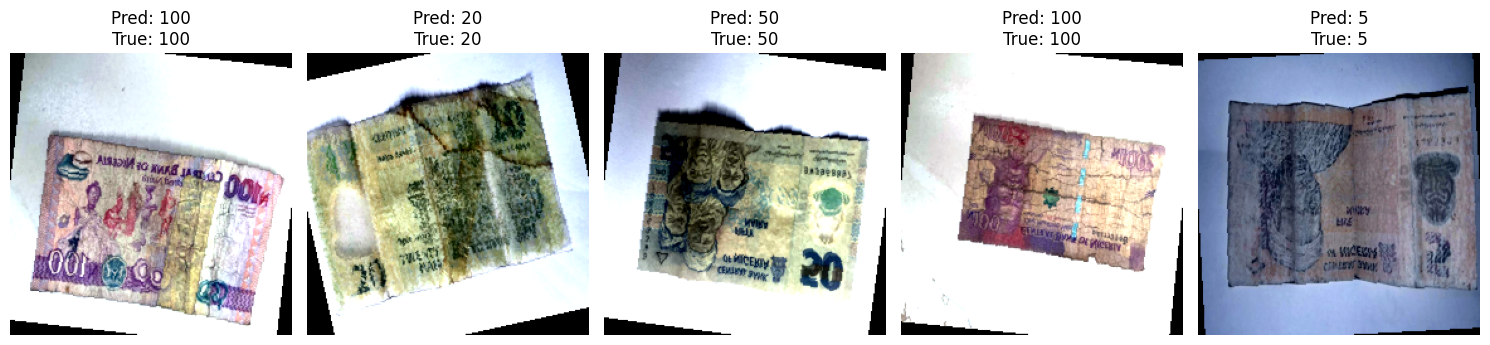

In [ ]:
show_random_predictions(model_resnet50, train_loader, train_dataset.classes, device)

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)

            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_acc = test_correct / test_total
    test_loss = test_loss / test_total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc
    })

In [ ]:
test_model(
    model=model_resnet50,
    test_loader=test_loader,
    criterion=loss_fn,
    device=device
)

Testing: 100%|██████████| 3/3 [01:01<00:00, 20.49s/it]

Test Loss: 0.0297 | Test Accuracy: 0.7222
              precision    recall  f1-score   support

          10       0.67      0.67      0.67         9
         100       0.89      0.67      0.76        12
        1000       0.52      0.92      0.67        12
          20       0.88      0.58      0.70        12
         200       0.56      0.83      0.67        12
           5       1.00      0.78      0.88         9
          50       0.83      0.83      0.83        12
         500       1.00      0.50      0.67        12

    accuracy                           0.72        90
   macro avg       0.79      0.72      0.73        90
weighted avg       0.79      0.72      0.73        90



In [ ]:
wandb.finish()

In [ ]:
import random
def show_random_predictions(model, test_loader, class_names, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)
    samples = [test_dataset[i] for i in indices]

    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(samples):
        input_img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
        with torch.no_grad():
            output = model(input_img)
            _, predicted = torch.max(output, 1)

        # Convert image back to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)  # Unnormalize if normalized earlier

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {class_names[predicted.item()]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

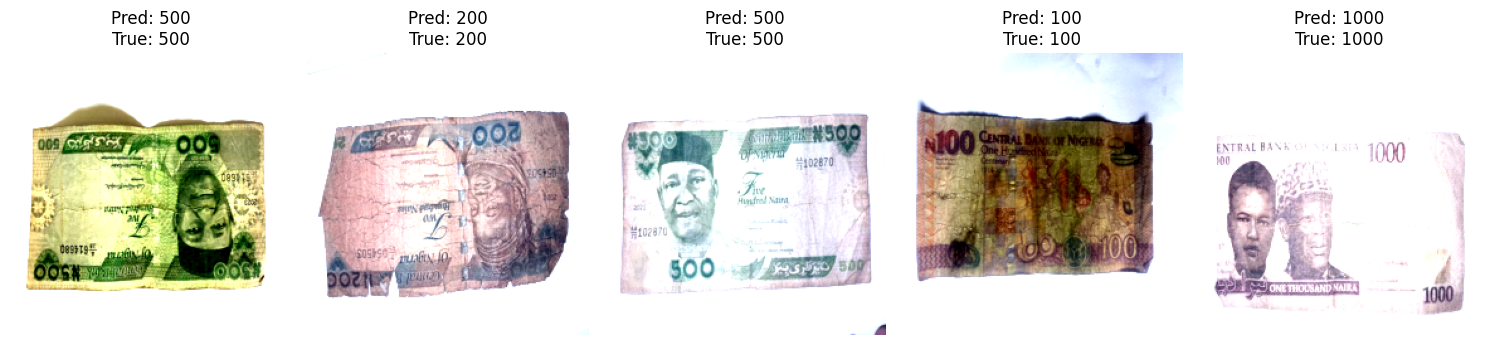

In [ ]:
show_random_predictions(model_resnet50, test_loader, test_dataset.classes, device)

In [ ]:
# Plot the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

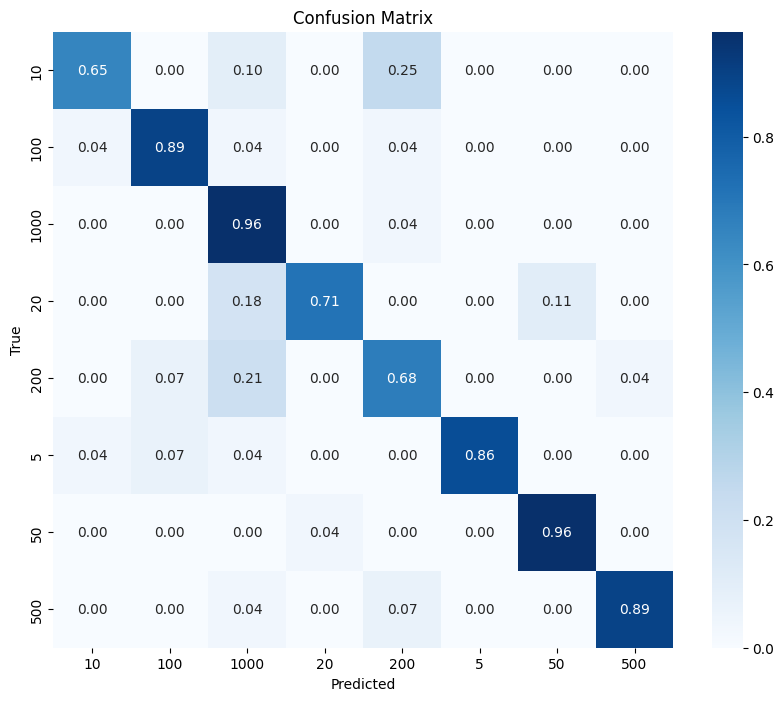

In [ ]:
plot_confusion_matrix(model_resnet50, val_loader, train_dataset.classes, device)

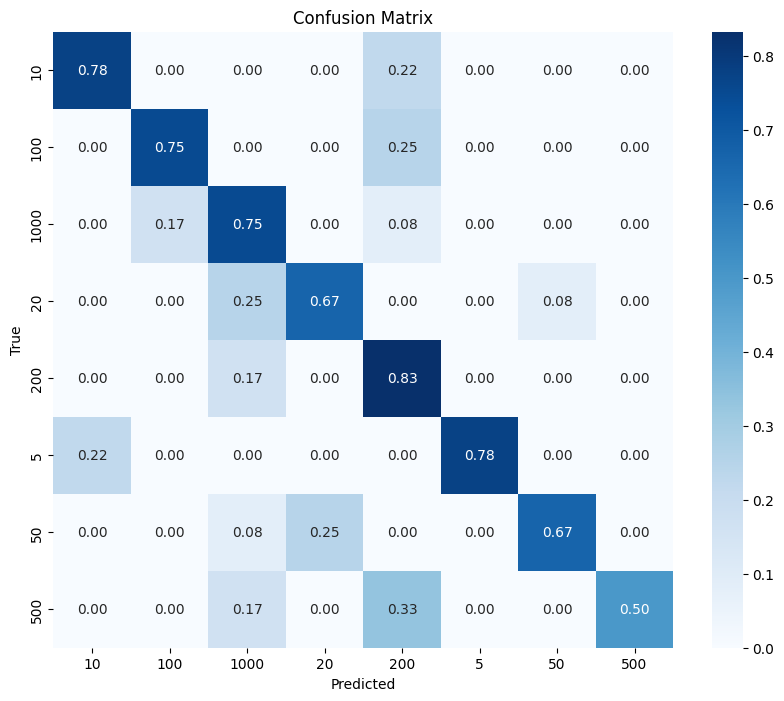

In [31]:
plot_confusion_matrix(model_resnet50, test_loader, test_dataset.classes, device)